## Import Libraries

In [3]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from rake_nltk import Rake

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Autocompletion
%config Completer.use_jedi = False

pd.set_option('display.max_colwidth', None)

## Load Data

In [64]:
camera_df = pd.read_excel('data/Smartphones_Camera.xlsx',sheet_name='result 1')

In [65]:
camera_df.head(5)

,attribute_name,sentence,indicator_phrase,sentiment
0,Camera,I'm not even impressed with the camera as I thought I would.,camera,-1
1,Camera,"But if you want a phone that is 5G ready, has ample memory, had a display that is as good or better than any others on the market, and has a spectacular three-lens camera that produces accurate color and functions extraordinarily well in low light (despite a small aperture), this is it.",camera,1
2,Camera,"Super handy, great display 'Battery life good, outstanding camera.",camera,1
3,Camera,"No problems with the update, great photos, fluid run and very clear.",photos,1
4,Camera,"Camera Good Super Slow Function Funny, IP68 Top, Micro SD good, battery firmly installed unfortunately, the S5 is better.",Camera,1


In [66]:
camera_df['sentence'].head(2)

0                                                                                                                                                                                                                                       I'm not even impressed with the camera as I thought I would.
1    But if you want a phone that is 5G ready, has ample memory, had a display that is as good or better than any others on the market, and has a spectacular three-lens camera that produces accurate color and functions extraordinarily well in low light (despite a small aperture), this is it.
Name: sentence, dtype: object

## Exploratory Data Analysis

In [67]:
### Summary of the dataset

camera_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   attribute_name    10000 non-null  object
 1   sentence          10000 non-null  object
 2   indicator_phrase  10000 non-null  object
 3   sentiment         10000 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 312.6+ KB


In [68]:
camera_df['attribute_name'].value_counts()

Camera    10000
Name: attribute_name, dtype: int64

In [69]:
camera_df['sentiment'].value_counts()

 1    6486
-1    2217
 0    1297
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment', ylabel='count'>

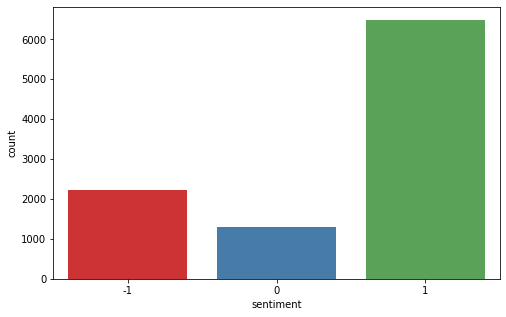

In [70]:
## Plot the counts of the sentiments in the new column

fig = plt.figure(figsize=(8,5))
sns.countplot(x='sentiment', data=camera_df, palette='Set1', order=[-1, 0, 1])

In [71]:
camera_df['indicator_phrase'].value_counts().head(5)

camera      4494
photos      1509
pictures     906
Camera       470
photo        338
Name: indicator_phrase, dtype: int64

In [72]:
## Check if the labels are mutually exclusive

camera_df[(camera_df['sentiment'] == -1) & ((camera_df['sentiment'] == 0) | (camera_df['sentiment'] == 1))].count()

attribute_name      0
sentence            0
indicator_phrase    0
sentiment           0
dtype: int64

In [73]:
# Check for only whitespace strings in sentence column

white_space = []  # start with an empty list

for i, _, sentence, _, _ in camera_df.itertuples():
    if type(sentence)==str and sentence.isspace():
        white_space.append(i)

len(white_space)

0

## Data Cleaning / Text Processing

### Convert text to lower case

In [74]:
def convert_to_lower_case(text):
    return " ".join(text.lower() for text in text.split())

camera_df['sentence'] = camera_df['sentence'].apply(lambda sentence: convert_to_lower_case(sentence))

In [75]:
# Check if the sentences have been lower-cased
camera_df['sentence'].head(2)

0                                                                                                                                                                                                                                       i'm not even impressed with the camera as i thought i would.
1    but if you want a phone that is 5g ready, has ample memory, had a display that is as good or better than any others on the market, and has a spectacular three-lens camera that produces accurate color and functions extraordinarily well in low light (despite a small aperture), this is it.
Name: sentence, dtype: object

### Contraction Mapping

In [76]:
def apply_contraction_mapping(text):
    contraction_mapping = {"ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because",
                           "could've": "could have", "couldn't": "could not",
                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                           "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will",
                           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
                           "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
                           "I'll've": "I will have", "I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have", "i'm": "i am",
                           "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have",
                           "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us",
                           "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not",
                           "mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
                           "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                           "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
                           "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
                           "she'll've": "she will have", "she's": "she is", "should've": "should have",
                           "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                           "so's": "so as",
                           "this's": "this is", "that'd": "that would", "that'd've": "that would have",
                           "that's": "that is",
                           "there'd": "there would", "there'd've": "there would have", "there's": "there is",
                           "here's": "here is",
                           "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
                           "they'll've": "they will have",
                           "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                           "we'd": "we would", "we'd've": "we would have", "we'll": "we will",
                           "we'll've": "we will have",
                           "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
                           "what'll've": "what will have",
                           "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is",
                           "when've": "when have",
                           "where'd": "where did", "where's": "where is", "where've": "where have",
                           "who'll": "who will",
                           "who'll've": "who will have",
                           "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have",
                           "will've": "will have",
                           "won't": "will not", "won't've": "will not have", "would've": "would have",
                           "wouldn't": "would not",
                           "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                           "y'all'd've": "you all would have",
                           "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would",
                           "you'd've": "you would have", "you'll": "you will",
                           "you'll've": "you will have", "you're": "you are", "you've": "you have"}
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(" ")])
    return text

In [77]:
camera_df['sentence'] = camera_df['sentence'].apply(apply_contraction_mapping)

In [78]:
# Check if the comtraction mapping is applied
camera_df['sentence'].head(2)

0                                                                                                                                                                                                                                      i am not even impressed with the camera as i thought i would.
1    but if you want a phone that is 5g ready, has ample memory, had a display that is as good or better than any others on the market, and has a spectacular three-lens camera that produces accurate color and functions extraordinarily well in low light (despite a small aperture), this is it.
Name: sentence, dtype: object

### Remove punctuations

In [79]:
def remove_punctuations(text):
    return re.sub(r'[^\w\s]','',text)

camera_df['sentence'] = camera_df['sentence'].apply(lambda sentence: remove_punctuations(sentence))

In [80]:
# Check if the punctuations are removed
camera_df['sentence'].head(2)

0                                                                                                                                                                                                                               i am not even impressed with the camera as i thought i would
1    but if you want a phone that is 5g ready has ample memory had a display that is as good or better than any others on the market and has a spectacular threelens camera that produces accurate color and functions extraordinarily well in low light despite a small aperture this is it
Name: sentence, dtype: object

### Fix Spelling Mistakes

#### TBD

### Remove stopwords

Sentence1: before -> i am **not even impressed** with the camera as i thought i would
after removing stopwords -> **even impressed** camera thought would

I do not think, we should use stopwords out of the box or other option would be to remove certain words from the stopwords corpus (like `not`)

In [92]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

# removing not 

stop_words.remove('not')
stop_words.remove('no')



#def remove_stopwords(text):
    #return " ".join(x for x in text.split() if x not in stop_words)

#camera_df['sentence'] = camera_df['sentence'].apply(lambda sentence: remove_stopwords(sentence))

[nltk_data] Downloading package stopwords to /Users/amit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [89]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [82]:
## Check if stopwords are removed 
#camera_df['sentence'].head(2)

### Lemmatization/Stemming

Not used, as I do not want to break the POS tagging or change the polarity of words.

# Key-phrase Extraction 

In [85]:
camera_df['sentence'].head(2)

0                                                                                                                                                                                                                               i am not even impressed with the camera as i thought i would
1    but if you want a phone that is 5g ready has ample memory had a display that is as good or better than any others on the market and has a spectacular threelens camera that produces accurate color and functions extraordinarily well in low light despite a small aperture this is it
Name: sentence, dtype: object

In [93]:
import pke

ModuleNotFoundError: No module named 'pke'